In [4]:
import numpy as np
from scipy.stats import norm
from sympy import Symbol, diff, erf, sqrt, init_printing, ln, exp, diff, lambdify
import matplotlib.pyplot as plt

%matplotlib inline

# General Math Background

$$
f(x) = f(a) + \frac{f^\prime(a)}{1!} (x-a) + \frac{f^{\prime\prime}(a)}{2!}(x-a)2 + \frac{f^{\prime\prime\prime}(A)}{3!}(x-a)3 + \cdots
$$

Consider $f(x) = \sin(X)$ expande around $x=0$.

\begin{array}{lc}
\mbox{First Derivative}     & \cos(x)     \\
\mbox{Second Derivative}    & -\sin(x)    \\
\mbox{Third Derivative}     & -\cos(x)    \\
\mbox{Fourth Derivative}    & \sin(x)     \\
\mbox{Fifth Derivative}     & \cos(x)
\end{array}

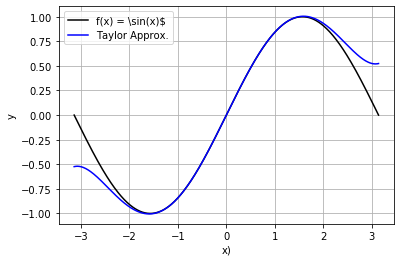

In [5]:
x = np.linspace(-np.pi, np.pi, 500)
y = np.sin(x)

plt.plot(x, y, 'k', label = 'f(x) = \sin(x)$')
plt.grid(True)
plt.xlabel('x)')
plt.ylabel('y')

#  First Order
taylor = np.sin(0) + np.cos(0)/np.math.factorial(1) * (x - 0)

#  Second Order
taylor = taylor + -np.sin(0) / np.math.factorial(2) * (x - 0)**2

# Third order
taylor = taylor + -np.cos(0) / np.math.factorial(3) * (x - 0)**3

#  Fourth order
taylor = taylor + np.sin(0) / np.math.factorial(4) * (x - 0)**4

#  Fifth order
taylor = taylor + np.cos(0) / np.math.factorial(5) * (x - 0)**5

plt.plot(x, taylor, 'b', label = 'Taylor Approx.')

plt.legend()

#  The Greeks

#  What are the Greeks?

In non-mathematical terms, the Greeks are a measurement of an option’s price sensitivity to small changes in some underlying variable such as price, time, or volatility.   In more mathematical terms, the Greeks are (partial) derivatives of the option price with respect to the quantity (or quantities) of interest.  

A bit of notation first, 
\begin{array}{lll}
S    &  =  &  \mbox{Stock Price} \\
K    &  =  &  \mbox{Strike Price} \\
r    &  =  &  \mbox{Risk-Free Rate} \\
t     &  =  &  \mbox{To Until Expiration} \\
\sigma   &  =  &  \mbox{Implied Volatility} \\
\end{array}


If you have a model that gives the option price $V$,

$$V(S, K, r, t, \sigma)$$


\begin{array}{ll}
\mbox{Delta}\:(\Delta)   & \frac{\partial V}{\partial S} \\
\mbox{Gamma}\:(\Gamma)   & \frac{\partial^2 V}{\partial S^2} \\
\mbox{Speed}                & \frac{\partial^3 V}{\partial S^3} \\
\quad\vdots                     & \vdots \\
\mbox{Theta}\:(\Theta)   & \frac{\partial V}{\partial t} \\
                            & \frac{\partial^2 V}{\partial t^2 } \\
\quad\vdots & \vdots
\end{array}
 

###  Black-Scholes Utility Functions

In [8]:
#  Black-Scholes formulas for call and put prices
def call_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    return C

def put_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    P = -np.multiply(S, norm.cdf(-d1)) + \
        np.multiply(norm.cdf(-d2) * K, np.exp(-r * t))
    return P

def theta(sigma,S, K, r, t, contract_type):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    if contract_type == 'c':
        theta = -S * sigma * norm.pdf(d1) / (2 * np.sqrt(t)) - r * K * np.exp(-r * t) * norm.cdf(d2)
    if contract_type == 'p':
        theta = -S * sigma * norm.pdf(-d1) / (2 * np.sqrt(t)) + r * K * np.exp(-r * t) * norm.cdf(-d2)

    return theta

###   Sympy Utility Functions
####  Time and spot Greeks for call options

In [6]:
def return_time_greeks(vol, SS, KK, rr, tt):

    S = Symbol('S', real = True)
    K = Symbol('K', real = True)
    r = Symbol('r', real = True)
    t = Symbol('t', real = True)
    sigma = Symbol('sigma', real = True)

    d1 = 1 / (sigma * sqrt(t)) * (ln(S/K) + (r + sigma**2 / 2) * t)
    d2 = d1 - sigma * sqrt(t)

    C = S * 0.5 * (1 + erf(d1 / sqrt(2))) - K * exp(-r * t) * 0.5 * (1 + erf(d2 / sqrt(2)))

    Dt1 = diff(C, t)
    Dt2 = diff(Dt1, t)
    Dt3 = diff(Dt2, t)
    Dt4 = diff(Dt3, t)
    Dt5 = diff(Dt4, t)
    Dt6 = diff(Dt5, t)
    
    output0 = lambdify( (sigma, S, K, r, t), C)
    output1 = lambdify( (sigma, S, K, r, t), Dt1)
    output2 = lambdify( (sigma, S, K, r, t), Dt2)
    output3 = lambdify( (sigma, S, K, r, t), Dt3)
    output4 = lambdify( (sigma, S, K, r, t), Dt4)
    output5 = lambdify( (sigma, S, K, r, t), Dt5)
    output6 = lambdify( (sigma, S, K, r, t), Dt6)
    
    return [output0(vol, SS, KK, rr, tt), 
            output1(vol, SS, KK, rr, tt), 
            output2(vol, SS, KK, rr, tt), 
            output3(vol, SS, KK, rr, tt), 
            output4(vol, SS, KK, rr, tt), 
            output5(vol, SS, KK, rr, tt), 
            output6(vol, SS, KK, rr, tt), ]


def return_price_greeks(vol, SS, KK, rr, tt):

    S = Symbol('S', real = True)
    K = Symbol('K', real = True)
    r = Symbol('r', real = True)
    t = Symbol('t', real = True)
    sigma = Symbol('sigma', real = True)

    d1 = 1 / (sigma * sqrt(t)) * (ln(S/K) + (r + sigma**2 / 2) * t)
    d2 = d1 - sigma * sqrt(t)

    C = S * 0.5 * (1 + erf(d1 / sqrt(2))) - K * exp(-r * t) * 0.5 * (1 + erf(d2 / sqrt(2)))

    dS1 = diff(C, S)
    dS2 = diff(dS1, S)
    dS3 = diff(dS2, S)
    dS4 = diff(dS3, S)
    dS5 = diff(dS4, S)
    dS6 = diff(dS5, S)

    output0 = lambdify( (sigma, S, K, r, t), C)
    output1 = lambdify( (sigma, S, K, r, t), dS1)
    output2 = lambdify( (sigma, S, K, r, t), dS2)
    output3 = lambdify( (sigma, S, K, r, t), dS3)
    output4 = lambdify( (sigma, S, K, r, t), dS4)
    output5 = lambdify( (sigma, S, K, r, t), dS5)
    output6 = lambdify( (sigma, S, K, r, t), dS6)

    return [output0(vol, SS, KK, rr, tt), 
        output1(vol, SS, KK, rr, tt), 
        output2(vol, SS, KK, rr, tt), 
        output3(vol, SS, KK, rr, tt), 
        output4(vol, SS, KK, rr, tt), 
        output5(vol, SS, KK, rr, tt), 
        output6(vol, SS, KK, rr, tt), ]

###  Time Greeks ($\Theta, \mbox{etc.}$)

C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


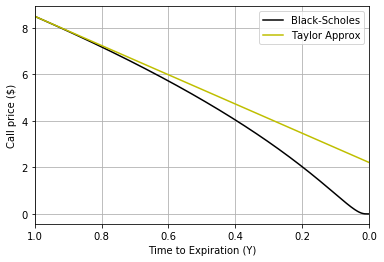

In [11]:
S = 100
K = 110
r = 0.01
t = 1
sigma = 0.3

tspan = np.linspace(1, 0, 366)
C = call_price(sigma, S, K, r, tspan)

plt.plot(tspan, C, 'k', label = 'Black-Scholes')
plt.xlim(1, 0)
plt.grid(True)
plt.xlabel('Time to Expiration (Y)')
plt.ylabel('Call price ($)')

time_greeks = return_time_greeks(sigma, S, K, r, t)

C0 = time_greeks[0]
dt1 = time_greeks[1]
dt2 = time_greeks[2]
dt3 = time_greeks[3]
dt4 = time_greeks[4]
dt5 = time_greeks[5]
dt6 = time_greeks[6]

taylor = C[0] + dt1 * (tspan - 1)
#taylor = taylor + dt2 / np.math.factorial(2) * (tspan-1)**2
#taylor = taylor + dt3 / np.math.factorial(3) * (tspan-1)**3
#taylor = taylor + dt4 / np.math.factorial(4) * (tspan-1)**4
#taylor = taylor + dt5 / np.math.factorial(5) * (tspan-1)**5
#taylor = taylor + dt6 / np.math.factorial(6) * (tspan-1)**6

plt.plot(tspan, taylor, 'y', label = 'Taylor Approx')
plt.legend()

###  Price Greeks ($\Delta, \Gamma, \mbox{ect.}$)

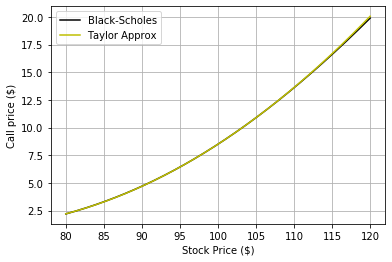

In [12]:
Sspan = np.linspace(80, 120, 500)
K = 110
r = 0.01
t = 1
sigma = 0.3

C = call_price(sigma, Sspan, K, r, t)

plt.plot(Sspan, C, 'k', label = 'Black-Scholes')
plt.xlabel('Stock Price ($)')
plt.ylabel('Call price ($)')
plt.grid(True)

S = 100

price_greeks = return_price_greeks(sigma, S, K, r, t)

C0 =  price_greeks[0]
dS1 = price_greeks[1]
dS2 = price_greeks[2]
dS3 = price_greeks[3]
dS4 = price_greeks[4]
dS5 = price_greeks[5]
dS6 = price_greeks[6]

taylor = C0 + dS1 * (Sspan - S)
taylor = taylor + dS2 / np.math.factorial(2) * (Sspan - S)**2

plt.plot(Sspan, taylor, 'y', label = 'Taylor Approx')
plt.legend()

###  Price Greeks with Shorter Time Horizon

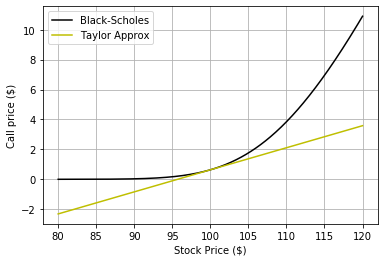

In [14]:
Sspan = np.linspace(80, 120, 500)
K = 110
r = 0.01
t = 1 / 12
sigma = 0.3

C = call_price(sigma, Sspan, K, r, t)

plt.plot(Sspan, C, 'k', label = 'Black-Scholes')
plt.xlabel('Stock Price ($)')
plt.ylabel('Call price ($)')
plt.grid(True)

S = 100

price_greeks = return_price_greeks(sigma, S, K, r, t)

C0 =  price_greeks[0]
dS1 = price_greeks[1]
dS2 = price_greeks[2]
dS3 = price_greeks[3]
dS4 = price_greeks[4]
dS5 = price_greeks[5]
dS6 = price_greeks[6]

taylor = C0 + dS1 * (Sspan - S)
#taylor = taylor + dS2 / np.math.factorial(2) * (Sspan - S)**2
#taylor = taylor + dS3 / np.math.factorial(3) * (Sspan - S)**3
#taylor = taylor + dS4 / np.math.factorial(4) * (Sspan - S)**4
#taylor = taylor + dS5 / np.math.factorial(5) * (Sspan - S)**5
#taylor = taylor + dS6 / np.math.factorial(6) * (Sspan - S)**6

plt.plot(Sspan, taylor, 'y', label = 'Taylor Approx')
plt.legend()